# 从零开始实现

In [13]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim = 0)
            var = ((X - mean) ** 2).mean(dim = 0)
        else:
            mean = X.mean(dim = (0, 2, 3), keepdim = True)
            var = ((X - mean) ** 2).mean(dim = (0, 2, 3), keepdim = True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

### 创建一个正确的BatchNorm图层

In [17]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps = 1e-5, momentum = 0.9)
        return Y

### 应用BatchNorm于LeNet模型

In [31]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5), BatchNorm(6, num_dims = 4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(6, 16, kernel_size = 5), BatchNorm(16, num_dims = 4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120), BatchNorm(120, num_dims=2), 
    nn.Sigmoid(), nn.Linear(120, 84), BatchNorm(84, num_dims=2), 
    nn.Sigmoid(), nn.Linear(84, 10))

### 在Fashion-MINIST数据集上训练网络

loss 0.245, train acc 0.911, test acc 0.888
36257.7 examples/sec on cuda:0


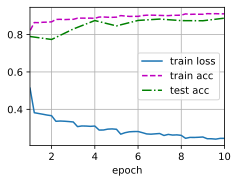

In [32]:
lr, num_epochs, batch_size = 0.4, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 拉伸参数gamma和偏移参数beta

In [33]:
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([2.4144, 1.0128, 1.2197, 1.1152, 2.2968, 1.3333], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<ViewBackward0>))

### 简明实现

In [38]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(6, 16, kernel_size = 5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size = 2, stride = 2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120), nn.BatchNorm1d(120), 
    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84), 
    nn.Sigmoid(), nn.Linear(84, 10))

### 使用相同超参数来训练网络

loss 0.221, train acc 0.919, test acc 0.894
54596.5 examples/sec on cuda:0


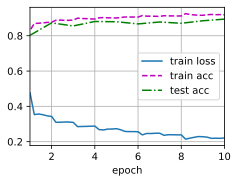

In [40]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 维度测试理解验证

In [12]:
X = torch.rand(size = (4, 3, 24, 36))
print('len_shape', len(X.shape))
print('X', X)
mean = X.mean(dim = (0, 2), keepdim = True)
var = ((X - mean) ** 2).mean(dim = (0, 2), keepdim = True)
print('mean:\t', mean)
print('var:\t', var)

len_shape 4
X tensor([[[[2.8129e-01, 5.1763e-01, 6.4091e-01,  ..., 5.2812e-01,
           5.7125e-01, 3.3109e-02],
          [3.9996e-01, 1.8684e-01, 7.5100e-01,  ..., 6.5205e-01,
           6.5603e-01, 5.0955e-02],
          [9.6738e-01, 8.6532e-01, 7.2316e-01,  ..., 4.7374e-01,
           1.1953e-01, 2.9956e-01],
          ...,
          [9.1384e-01, 2.8187e-01, 6.2230e-01,  ..., 8.5925e-01,
           9.3834e-01, 5.3995e-02],
          [5.7100e-01, 8.6095e-01, 7.2071e-01,  ..., 3.8661e-01,
           1.3790e-01, 8.9920e-01],
          [2.0876e-01, 4.7934e-02, 4.1915e-01,  ..., 4.4747e-01,
           6.4121e-01, 6.4624e-01]],

         [[6.9209e-01, 6.7508e-01, 8.2413e-01,  ..., 9.7021e-01,
           3.2645e-01, 5.9348e-01],
          [7.0315e-01, 8.9606e-01, 8.3697e-01,  ..., 2.4132e-01,
           5.8659e-01, 5.4879e-01],
          [6.0347e-01, 3.1677e-01, 7.2300e-01,  ..., 5.6887e-02,
           7.5343e-02, 9.2779e-01],
          ...,
          [3.6291e-01, 6.0852e-01, 6.8327e-01